## Import Python Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload

## Import Utility Classes

In [2]:
%autoreload 2
import sys
sys.path.append('..')

from utils.data_loader import DataLoader
from utils.term_counter_helper import TermFrequency, TfIdf
from utils.data_frame_helper import DataFrameHelper
from utils.dimensionality_reducer_helper import DimensionalityReducer

## Load Data

In [3]:
loader = DataLoader()
content = loader.load_data("../Data/trainingdata.txt")

Number of Rows:  5485



In [4]:
label_names = np.array(["A", "B", "C", "D", "E", "F", "G", "H"])
df = loader.get_data_frame(content, label_names)
df_helper = DataFrameHelper(df, label_names)

5485 documents
8 categories


## Input Dataset in DataFrame Format

In [5]:
df_helper.df.head()

,Labels,Text
0,A,champion products ch approves stock split cham...
1,B,computer terminal systems cpml completes sale ...
2,A,cobanco inc cbco year net shr cts vs dlrs net ...
3,A,am international inc am nd qtr jan oper shr lo...
4,A,brown forman inc bfd th qtr net shr one dlr vs...


## Vectorization of Text Data with TF-IDF Featurization

In [6]:
min_df = 2

tfidf = TfIdf(
    label_names,
    norm='l2',
    smooth_idf = True,
    sublinear_tf = False,
    lowercase=True,
    preprocessor=None,
    tokenizer=None,
    stop_words='english',
    ngram_range=(1, 1),
    analyzer='word',
    max_df=0.8, # 0.5, 0.75, 1.0
    min_df = min_df,
    max_features=None,
    vocabulary=None)



tfidf.vectorize_corpus(df_helper.raw_text)
tfidf.vectorizer

Feature Matrix:
n_samples: 5485 
n_features: 10416


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [7]:
reducer = DimensionalityReducer(tfidf.X)

In [8]:
X_pca = reducer.fit_reducer("PCA", n_components=100)

Explained variance of the SVD step: 36%


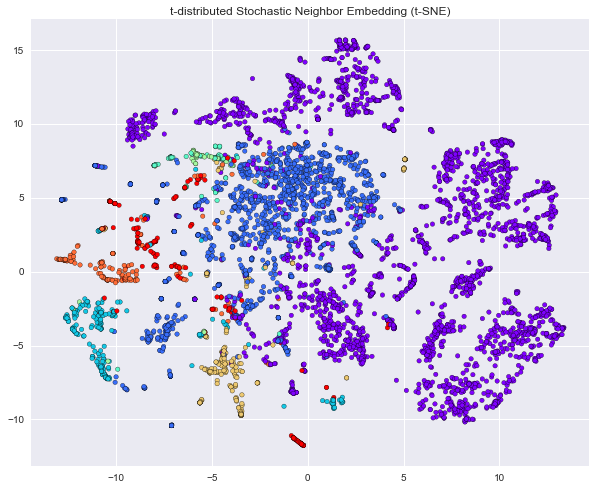

In [10]:
reducer.plot_TSNE_projection(X_pca, df_helper.y)

In [11]:
X_SVD = reducer.fit_reducer("TruncatedSVD", n_components=100)

Explained variance of the signal decomposition step: 36%


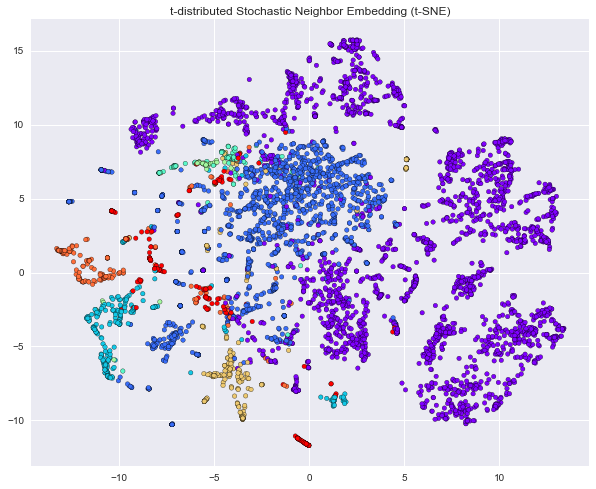

In [12]:
reducer.plot_TSNE_projection(X_SVD, df_helper.y)

In [13]:
X_kPCA = reducer.fit_reducer("KernelPCA", n_components=100)

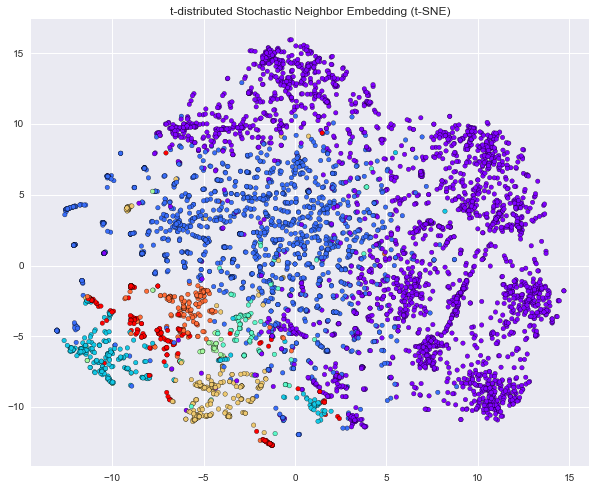

In [14]:
reducer.plot_TSNE_projection(X_kPCA, df_helper.y)

In [55]:
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn import metrics

In [ ]:
print("Computing t-SNE embedding...")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_reduced).T
plt.scatter(X_tsne[0], X_tsne[1], c=df_helper.y, cmap=plt.cm.rainbow)
plt.show()

In [42]:
print("Performing dimensionality reduction using LSA")
svd = TruncatedSVD(n_components=2, n_iter=10)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(tfidf.X)

def explained_variance(decomposer):
    explained_variance = decomposer.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))


Performing dimensionality reduction using LSA
Explained variance of the SVD step: 10%



In [48]:
label_names = np.array(["A", "B", "C", "D", "E", "F", "G", "H"])
# len(label_names)
km = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=10, n_jobs=-1)

print("Clustering sparse data with %s" % km)
km.fit(X)
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(df_helper.y, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(df_helper.y, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(df_helper.y, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(df_helper.y, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()

Clustering sparse data with KMeans(copy_x=True, init='k-means++', max_iter=100, n_clusters=3, n_init=10,
    n_jobs=-1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

Homogeneity: 0.105
Completeness: 0.133
V-measure: 0.117
Adjusted Rand-Index: 0.181
Silhouette Coefficient: 0.630



In [49]:
print("Top terms per cluster:")

original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = tfidf.vectorizer.get_feature_names()
for i in range(len(label_names)):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Top terms per cluster:
Cluster 0: cts qtly div vs april record pay prior dividend march
Cluster 1: vs mln loss cts net shr profit revs dlrs qtr
Cluster 2: vs cts mln net qtly div april record prior pay
Cluster 3:

IndexError: index 3 is out of bounds for axis 0 with size 3

In [51]:
svd = TruncatedSVD(n_components=2, n_iter=10)
X = svd.fit_transform(tfidf.X)

In [58]:
X = PCA(n_components=2).fit_transform(tfidf.X.toarray())

In [73]:
km = KMeans(n_clusters=2, init='k-means++', max_iter=200, n_init=10, n_jobs=-1)

print("Clustering sparse data with %s" % km)
km.fit(X)

Clustering sparse data with KMeans(copy_x=True, init='k-means++', max_iter=200, n_clusters=2, n_init=10,
    n_jobs=-1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)


KMeans(copy_x=True, init='k-means++', max_iter=200, n_clusters=2, n_init=10,
    n_jobs=-1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [74]:
tfidf.X.shape

(5485, 10416)

In [75]:
X.shape

(5485, 2)

In [76]:
df_helper.y.shape

(5485,)

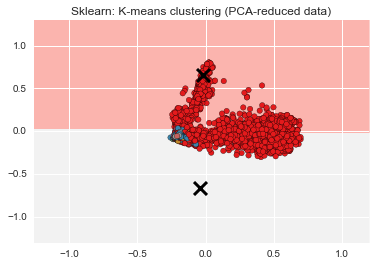

In [77]:
plot_decision_boundary(km, X, df_helper.y)
plt.title('Sklearn: K-means clustering (PCA-reduced data)')
plt.show()

In [79]:
from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

Computing t-SNE embedding


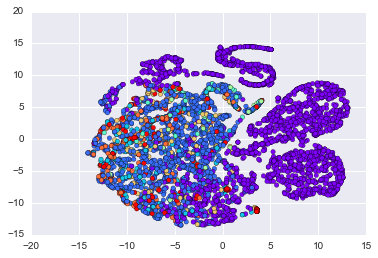

In [91]:
svd = TruncatedSVD(n_components=4, n_iter=10)
X_reduced = svd.fit_transform(tfidf.X)

# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne2 = tsne.fit_transform(X_reduced).T
plt.scatter(X_tsne2[0], X_tsne2[1], c=df_helper.y, cmap=plt.cm.rainbow)

In [86]:
svd = TruncatedSVD(n_components=100, n_iter=10)
X_reduced = svd.fit_transform(tfidf.X)

Computing t-SNE embedding


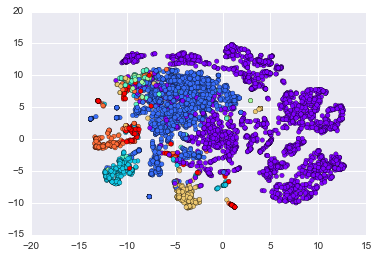

In [88]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne2 = tsne.fit_transform(X_reduced).T
plt.scatter(X_tsne2[0], X_tsne2[1], c=df_helper.y, cmap=plt.cm.rainbow)

In [83]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(tfidf.X.toarray()).T

Computing t-SNE embedding


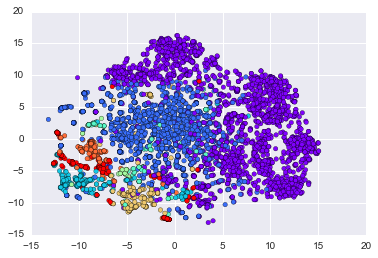

In [85]:
plt.scatter(X_tsne[0], X_tsne[1], c=df_helper.y, cmap=plt.cm.rainbow)

# plot_embedding(X_tsne,
#                "t-SNE embedding of the digits (time %.2fs)" %
#                (time() - t0))

plt.show()